In [173]:
import pandas as pd
import numpy as np
import sys
import os
import csv
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

dataset_properties = {'jester': {'n_folds': 8,
                       'evaluation_predicate': 'rating'
                                }, 
                      'epinions': {'n_folds': 8,
                                   'evaluation_predicate': 'trusts'
                                  },
                      'cora': {'n_folds': 8, 
                               'evaluation_predicate': 'hasCat'
                              },
                      'citeseer': {'n_folds': 8,
                                   'evaluation_predicate': 'hasCat'
                                  },
                      'lastFM': {'n_folds': 5, 
                                 'evaluation_predicate': 'rating'
                                }
                     }

# weight_learning_methods = ["BOWLSS", "BOWLOS", "LME", "MLE",
#            "MPLE", "RGS", "CRGS", "HB"]

weight_learning_methods = {"psl": ["BOWLSS", "BOWLOS", "UNIFORM"],
                           "tuffy": ["UNIFORM"]}

In [90]:
!pwd

/scratch/charles/SRLWeightLearning/scripts


In [191]:
# dataset="epinions"
# wl_method="UNIFORM"
# evaluation_metric="Discrete"
# fold=0
# predicate="trusts"

dataset="citeseer"
wl_method="MLE"
evaluation_metric="Categorical"
fold=1
predicate="hasCat"

# dataset="jester"
# wl_method="UNIFORM"
# evaluation_metric="Continuous"
# fold=0
# predicate="rating"

In [192]:
def load_file(filename):
    output = []

    with open(filename, 'r') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        for line in reader:
            output.append(line)

    return output


def load_observed_frame(dataset, fold, predicate, phase='eval'):
    # path to this file relative to caller
#     dirname = os.path.dirname(__file__)
    dirname='.'

    observed_path = "{}/../psl-examples/{}/data/{}/{}/{}/{}_obs.txt".format(dirname, dataset, dataset, fold, phase, predicate)
    observed_df = pd.read_csv(observed_path, sep='\t', header=None)

    # clean up column names and set multi-index for predicate
    arg_columns = ['arg_' + str(col) for col in observed_df.columns[:-1]]
    value_column = ['val']
    observed_df.columns = arg_columns + value_column
    observed_df = observed_df.astype({col: int for col in arg_columns})
    observed_df = observed_df.set_index(arg_columns)

    return observed_df


def load_truth_frame(dataset, fold, predicate, phase='eval'):
    # path to this file relative to caller
#     dirname = os.path.dirname(__file__)
    dirname='.'

    truth_path = "{}/../psl-examples/{}/data/{}/{}/{}/{}_truth.txt".format(dirname, dataset, dataset, fold, phase, predicate)
    truth_df = pd.read_csv(truth_path, sep='\t', header=None)

    # clean up column names and set multi-index for predicate
    arg_columns = ['arg_' + str(col) for col in truth_df.columns[:-1]]
    value_column = ['val']
    truth_df.columns = arg_columns + value_column
    truth_df = truth_df.astype({col: int for col in arg_columns})
    truth_df = truth_df.set_index(arg_columns)

    return truth_df


def load_target_frame(dataset, fold, predicate, phase='eval'):
    # path to this file relative to caller
    #     dirname = os.path.dirname(__file__)
    dirname='.'

    # TODO: (Charles D.) This is a hack, there should be a way to find what
    #  the suffix should be for this file from the cli in the psl-examples but its either target or targets
    try:
        target_path = "{}/../psl-examples/{}/data/{}/{}/{}/{}_target.txt".format(dirname, dataset, dataset, fold,
                                                                                 phase, predicate)
        target_df = pd.read_csv(target_path, sep='\t', header=None)
    except FileNotFoundError as err:
        target_path = "{}/../psl-examples/{}/data/{}/{}/{}/{}_targets.txt".format(dirname, dataset, dataset, fold,
                                                                                  phase, predicate)
        target_df = pd.read_csv(target_path, sep='\t', header=None)
        

    # clean up column names and set multi-index for predicate
    arg_columns = ['arg_' + str(col) for col in target_df.columns]
    target_df.columns = arg_columns
    target_df = target_df.astype({col: int for col in arg_columns})
    target_df = target_df.set_index(arg_columns)

    return target_df

In [193]:
def load_prediction_frame(dataset, wl_method, evaluation_metric, fold, predicate):
    # path to this file relative to caller
    #     dirname = os.path.dirname(__file__)
    dirname='./psl_scripts'

    # predicted dataframe
    predicted_path = "{}/../../results/weightlearning/psl/performance_study/{}/{}/{}/{}/inferred-predicates/{}.txt".format(
        dirname, dataset, wl_method, evaluation_metric, fold, predicate.upper())
    predicted_df = pd.read_csv(predicted_path, sep='\t', header=None)

    # clean up column names and set multi-index for predicate
    arg_columns = ['arg_' + str(col) for col in predicted_df.columns[:-1]]
    value_column = ['val']
    predicted_df.columns = arg_columns + value_column
    predicted_df = predicted_df.astype({col: int for col in arg_columns})
    predicted_df = predicted_df.set_index(arg_columns)

    return predicted_df

In [194]:
target_df = load_target_frame(dataset, fold, predicate, phase='eval')
observed_df = load_observed_frame(dataset, fold, predicate, phase='eval')
truth_df = load_truth_frame(dataset, fold, predicate, phase='eval')

truth_df.index.isin(observed_df.index).sum()

842

In [199]:
def evaluate_mse(predicted_df, truth_df, observed_df, target_df):
    # consider overlap between observed and truths if there is observed truths
    complete_predictions = observed_df.append(predicted_df)
    complete_predictions = complete_predictions.loc[~complete_predictions.index.duplicated(keep='first')]
    
    # evaluator indices
    evaluator_indices = truth_df.index.intersection(target_df.index)

    # Join predicted_df and truth_df on the arguments 
    experiment_frame = truth_df.loc[evaluator_indices].join(complete_predictions, how="left",
                                                            lsuffix='_truth', rsuffix='_predicted')
    
    return mean_squared_error(experiment_frame.val_truth, experiment_frame.val_predicted)


def evaluate_accuracy(predicted_df, truth_df, observed_df, target_df):
    # consider overlap between observed and truths if there is observed truths
    complete_predictions = observed_df.append(predicted_df)
    complete_predictions = complete_predictions.loc[~complete_predictions.index.duplicated(keep='first')]

    # use the category with the highest value as prediction, subset by target index
    predicted_categories_df = complete_predictions.loc[target_df.index].groupby(level=0).transform(
        lambda x: x.index.isin(x.iloc[[x.argmax()]].index))
    
    # boolean for truth df type
    truth_df = (truth_df == 1)
    
    # Join predicted_df and truth_df on the arguments
    # By right joining and filling with False we are closing the truth since the
    # predicted_categories_df should have all targets and the truth frame may only have the positives
    experiment_frame = truth_df.join(predicted_categories_df, how="right",
                                     lsuffix='_truth', rsuffix='_predicted').fillna(False)
    
    return accuracy_score(experiment_frame.val_truth, experiment_frame.val_predicted)


def evaluate_f1(predicted_df, truth_df, observed_df, target_df, threshold=0.5):
    # consider overlap between observed and truths if there is observed truths
    complete_predictions = observed_df.append(predicted_df)
    complete_predictions = complete_predictions.loc[~complete_predictions.index.duplicated(keep='first')]
    
    # use the category with the highest value as prediction, subset by target index
    predicted_categories_df = complete_predictions.loc[target_df.index].groupby(level=0).transform(
        lambda x: x.index.isin(x.iloc[[x.argmax()]].index))
    
    # boolean for truth df type
    truth_df = (truth_df == 1)
    
    # By right joining and filling with 0 we are closing the truth since the
    # complete_predictions.loc[target_df.index] should have all targets and the
    # truth frame may only have the positives
    experiment_frame = truth_df.join(predicted_categories_df, how="right",
                                     lsuffix='_truth', rsuffix='_predicted').fillna(False)
    
    return f1_score(experiment_frame.val_truth, experiment_frame.val_predicted, pos_label=True)


def evaluate_roc_auc_score(predicted_df, truth_df, observed_df, target_df, threshold=0.5):
    # consider overlap between observed and truths if there is observed truths
    complete_predictions = observed_df.append(predicted_df)
    complete_predictions = complete_predictions.loc[~complete_predictions.index.duplicated(keep='first')]
    
    # evaluator indices
    evaluator_indices = truth_df.index.intersection(target_df.index)

    # Join predicted_df and truth_df on the arguments
    # By right joining and filling with 0 we are closing the truth since the
    # complete_predictions.loc[target_df.index] should have all targets and the
    # truth frame may only have the positives
    experiment_frame = truth_df.loc[evaluator_indices].join(complete_predictions.loc[target_df.index], how="right",
                                     lsuffix='_truth', rsuffix='_predicted').fillna(0)

    relevant = experiment_frame.val_truth > threshold
    return roc_auc_score(relevant, experiment_frame.val_predicted)

In [200]:
evaluator_name_to_method = {
    'Categorical': evaluate_accuracy,
    'Discrete': evaluate_f1,
    'Continuous': evaluate_mse,
    'Ranking': evaluate_roc_auc_score
}

In [201]:
predicted_df=load_prediction_frame(dataset, wl_method, evaluation_metric, fold, predicate)
truth_df=load_truth_frame(dataset, fold, predicate)
observed_df=load_observed_frame(dataset, fold, predicate)
target_df=load_target_frame(dataset, fold, predicate)
evaluate_accuracy(predicted_df, truth_df, observed_df, target_df)

0.829953488372093

In [108]:
truth_df.index.intersection(target_df.index)

MultiIndex([(2374, 4),
            (2807, 2),
            ( 527, 1),
            (1932, 5),
            (3029, 4),
            (2092, 4),
            (2340, 3),
            ( 649, 4),
            (2183, 2),
            (2947, 3),
            ...
            (1739, 5),
            (2468, 5),
            (2542, 4),
            (3280, 3),
            (1874, 5),
            (1558, 5),
            (2924, 5),
            (1705, 6),
            (1792, 2),
            ( 165, 3)],
           names=['arg_0', 'arg_1'], length=814)

In [306]:
def write_performance_results(method):
    # in results/weightlearning/{}/performance_study write 
    # a performance.csv file with columns 
    # Dataset | WL_Method | Evaluation_Method | Mean | Standard_Deviation
    
    # we are going to overwrite the file with all the most up to date information
    
    performance_frame = pd.DataFrame(columns=['Dataset', 'Wl_Method', 'Evaluation_Method', 'Mean', 'Standard_Deviation'])
    
    # extract all the files that are in the results directory
    path = '../results/weightlearning/{}/performance_study'.format(method)
    datasets = [dataset for dataset in os.listdir(path) if os.path.isdir(os.path.join(path, dataset))]
    
    # iterate over all datasets adding the results to the performance_frame
    for dataset in datasets:
        # extract all the wl_methods that are in the directory
        path = '../results/weightlearning/{}/performance_study/{}'.format(method, dataset)
        wl_methods = [wl_method for wl_method in os.listdir(path) if os.path.isdir(os.path.join(path, wl_method))]
        
        for wl_method in wl_methods:
            # extract all the metrics that are in the directory
            path = '../results/weightlearning/{}/performance_study/{}/{}'.format(method, dataset, wl_method)
            evaluators = [evaluator for evaluator in os.listdir(path) if os.path.isdir(os.path.join(path, evaluator))]

            for evaluator in evaluators:
                # extract all the folds that are in the directory
                path = '../results/weightlearning/{}/performance_study/{}/{}/{}'.format(method, dataset, wl_method, evaluator)
                folds = [fold for fold in os.listdir(path) if os.path.isdir(os.path.join(path, fold))]
                
                # initialize the experiment list that will be populated in the following for 
                # loop with the performance outcome of each fold
                experiment_performance = np.array([])

                for fold in folds:
                    # load the prediction dataframe
                    try:
                        # prediction dataframe
                        if method == 'psl':
                            predicted_df = load_psl_prediction_frame(dataset, wl_method, evaluator, fold, 
                                                                     dataset_properties[dataset]['evaluation_predicate'])
                        elif method == 'tuffy':
                            predicted_df = load_tuffy_prediction_frame(dataset, wl_method, evaluator, fold, 
                                                                       dataset_properties[dataset]['evaluation_predicate'])
                        else:
                            raise IllegalArgumentError("{} not supported. Try: ['psl', 'tuffy']".format(method))
                    except FileNotFoundError as err:
                        print(err)
                        continue
                    
                    # truth dataframe 
                    truth_df = load_truth_frame(dataset, fold, dataset_properties[dataset]['evaluation_predicate'])
                    # observed dataframe
                    observed_df = load_observed_frame(dataset, fold, dataset_properties[dataset]['evaluation_predicate'])
                    
                    experiment_performance = np.append(experiment_performance, 
                                                       evaluator_name_to_method[evaluator](predicted_df, truth_df, observed_df))
    
                # update the performance_frame
                performance_series = pd.Series(index=['Dataset', 'Wl_Method', 'Evaluation_Method', 'Mean', 'Standard_Deviation'],
                                               dtype=float)
                performance_series['Dataset'] = dataset
                performance_series['Wl_Method'] = wl_method
                performance_series['Evaluation_Method'] = evaluator
                performance_series['Mean'] = experiment_performance.mean()
                performance_series['Standard_Deviation'] = experiment_performance.std()
                
                performance_frame = performance_frame.append(performance_series, ignore_index=True)
                
    # write results frame to results/weightlearning/{}/performance_study
    #performance_frame.to_csv('../results/weightlearning/{}/performance_study/{}_performance.csv'.format(method, method), index=False)
    return performance_frame

In [190]:
# add the percent increase for each dataset and evaluator
performance_results = pd.read_csv("../results/weightlearning/psl/performance_study/psl_performance.csv")
performance_results['PCT_Increase'] = 0
for dataset in performance_results.Dataset.unique():
    dataset_performance = performance_results[performance_results.Dataset == dataset]
    for Evaluation_Method in dataset_performance.Evaluation_Method.unique():
        evaluator_performance = dataset_performance[dataset_performance.Evaluation_Method == Evaluation_Method]
        Uniform_performance = evaluator_performance[evaluator_performance.Wl_Method == "UNIFORM"].Mean.values[0]
        pct_increase = ((evaluator_performance.Mean - Uniform_performance) / Uniform_performance) * 100
        performance_results.loc[evaluator_performance.index, "PCT_Improved"] = pct_increase

performance_results.to_csv('../results/weightlearning/psl/performance_study/psl_performance.csv', index=False)

In [294]:
def write_timing_results(method):
    # In results/weightlearning/psl/performance_study write a {}_timing.csv file with columns 
    # WL_Method | Dataset | Evaluation_Method | Mean_User_Time | Mean_Sys_Time | 
    
    # we are going to overwrite the file with all the most up to date information
    timing_frame = pd.DataFrame(columns=['Dataset', 'Wl_Method', 'Evaluation_Method', 'Mean_User_Time', 
                                         'Mean_Sys_Time', 'Sys_Time_Standard_Deviation', 'User_Time_Standard_Deviation'])
    
    # extract all the files that are in the results directory
    path = '../results/weightlearning/{}/performance_study'.format(method)
    datasets = [dataset for dataset in os.listdir(path) if os.path.isdir(os.path.join(path, dataset))]
    
    # iterate over all datasets adding the results to the timing_frame
    for dataset in datasets:
        # extract all the wl_methods that are in the directory
        path = '../results/weightlearning/{}/performance_study/{}'.format(method, dataset)
        wl_methods = [wl_method for wl_method in os.listdir(path) if os.path.isdir(os.path.join(path, wl_method))]
        
        for wl_method in wl_methods:
            # extract all the metrics that are in the directory
            path = '../results/weightlearning/{}/performance_study/{}/{}'.format(method, dataset, wl_method)
            evaluators = [evaluator for evaluator in os.listdir(path) if os.path.isdir(os.path.join(path, evaluator))]

            for evaluator in evaluators:
                # extract all the folds that are in the directory
                path = '../results/weightlearning/{}/performance_study/{}/{}/{}'.format(method, dataset, wl_method, evaluator)
                folds = [fold for fold in os.listdir(path) if os.path.isdir(os.path.join(path, fold))]
                
                # initialize the experiment_timing_frame that will be populated in the following for loop
                experiment_timing_frame = pd.DataFrame(columns=['User time (seconds)', 'System time (seconds)'])

                for fold in folds:
                    path = '../results/weightlearning/{}/performance_study/{}/{}/{}/{}'.format(
                        method, dataset, wl_method, evaluator, fold
                    )
                    # load the prediction dataframe
                    try:
                        # timing series for fold
                        fold_timing_series = pd.read_csv(path + '/time.txt', sep=': ', engine='python', header=None, index_col=0)
                        # add fold timing to experiment timing
                        experiment_timing_frame = experiment_timing_frame.append(
                            fold_timing_series.loc[['User time (seconds)', 'System time (seconds)'], 1],
                            ignore_index=True
                        )
                    except (FileNotFoundError, pd.errors.EmptyDataError, KeyError) as err:
                        print('{}: {}'.format(path, err))
                        continue
    
                # parse the timing series
                timing_series = pd.Series(index=['Dataset', 'Wl_Method', 'Mean_User_Time', 'Mean_Sys_Time', 
                                                 'User_Time_Standard_Deviation', 'Sys_Time_Standard_Deviation'],
                                               dtype=float)
                experiment_timing_frame = experiment_timing_frame.astype({'User time (seconds)': float,
                                                                          'System time (seconds)': float})
                timing_series['Dataset'] = dataset
                timing_series['Wl_Method'] = wl_method
                timing_series['Mean_User_Time'] = experiment_timing_frame['User time (seconds)'].mean()
                timing_series['Mean_Sys_Time'] = experiment_timing_frame['System time (seconds)'].mean()
                timing_series['User_Time_Standard_Deviation'] = experiment_timing_frame['User time (seconds)'].std()
                timing_series['Sys_Time_Standard_Deviation'] = experiment_timing_frame['System time (seconds)'].std()
                timing_frame = timing_frame.append(timing_series, ignore_index=True)
                
    # write results frame to results/weightlearning/{}/performance_study
    timing_frame.to_csv('../results/weightlearning/{}/performance_study/{}_timing.csv'.format(method, method), index=False)

In [ ]:
write_timing_results('psl')

../results/weightlearning/psl/performance_study/lastfm/RGS/Continuous/1: No columns to parse from file
../results/weightlearning/psl/performance_study/epinions/HB/Ranking/6: 1


In [152]:
predicted_df = load_psl_prediction_frame(dataset, wl_method, evaluation_metric, 0, dataset_properties[dataset]['evaluation_predicate'])
truth_df = load_truth_frame(dataset, 0, dataset_properties[dataset]['evaluation_predicate'])
observed_df = load_observed_frame(dataset, 0, dataset_properties[dataset]['evaluation_predicate'])
targets_df = load_target_frame(dataset, 0, dataset_properties[dataset]['evaluation_predicate'])

In [159]:
# Join predicted_df and truth_df on the arguments 
threshold = 0.5
complete_predictions = observed_df.append(predicted_df)
experiment_frame = truth_df.join(complete_predictions, how="left", 
                                 lsuffix='_truth', rsuffix='_predicted').fillna(0)

rounded_predictions = experiment_frame.val_predicted > threshold
rounded_truths = experiment_frame.val_truth > threshold

f1_score(rounded_truths, rounded_predictions, pos_label=True)

0.7774086378737541

In [157]:
targets_df.shape

(1656, 1)

In [99]:
write_psl_performance_results()

[Errno 2] File ../results/weightlearning/psl/performance_study/cora/BOWLSS/Categorical/2/inferred-predicates/HASCAT.txt does not exist: '../results/weightlearning/psl/performance_study/cora/BOWLSS/Categorical/2/inferred-predicates/HASCAT.txt'
     Dataset Wl_Method Evaluation_Method      Mean  Standard_Deviation
0       cora    BOWLOS       Categorical  0.956505            0.002855
1       cora    BOWLOS          Discrete  0.463495            0.019231
2       cora   UNIFORM       Categorical  0.956452            0.003773
3       cora   UNIFORM          Discrete  0.367932            0.017214
4       cora    BOWLSS       Categorical  0.955041            0.003231
5     jester       RGS           Ranking  0.767714            0.003209
6     jester       RGS        Continuous  0.053321            0.001119
7     jester        HB           Ranking  0.766385            0.001948
8     jester        HB        Continuous  0.069226            0.000335
9     jester    BOWLOS           Ranking  0.769

,,val
arg_0,arg_1,
2,4,1.0
4,3,1.0
5,2,1.0
10,6,1.0
12,1,1.0
...,...,...
3307,5,1.0
3308,3,1.0
3309,5,1.0


In [75]:
predicted_df.sort_index()

val
arg_0 arg_1          
2     1      0.074147
      2      0.074147
      3      0.079410
      4      0.100749
      5      0.521938
...               ...
3311  2      0.000000
      4      0.000000
      5      0.000000
      6      0.000000
      7      0.000000

[10750 rows x 1 columns]

In [19]:
# build single dataframe for each dataset
for dataset_name in datasets.keys():
    datasets[dataset_name]["dataframe"] = pd.DataFrame(index=range(datasets[dataset_name]["n_folds"]));
    datasets[dataset_name]["dataframe"].index.name = 'fold'
    for evaluation_method in datasets[dataset_name]["evaluation_methods"]:
        for wl_method in weight_learning_methods:
            results = pd.read_csv(dataset_name + '/' + dataset_name + "-" + wl_method + "-eval-" + evaluation_method + ".csv", header=None).values[0]
            results = results[:datasets[dataset_name]['n_folds']]
            datasets[dataset_name]["dataframe"][evaluation_method + "_" + wl_method] = results

columns=set()
for dataset_name in datasets.keys():
    for evaluation_method in datasets[dataset_name]["evaluation_methods"]:
        columns.add(dataset_name + '_' + evaluation_method + '_mean')
        columns.add(dataset_name + '_' + evaluation_method + '_standardDeviation')

performance_dataframe = pd.DataFrame(index=weight_learning_methods, columns=columns)
for wl_method in weight_learning_methods:
    for dataset_name in datasets.keys():
        for evaluation_method in datasets[dataset_name]["evaluation_methods"]:
            results = pd.read_csv(dataset_name + '/' + dataset_name + "-" + wl_method + "-eval-" + evaluation_method + ".csv", header=None).values[0]
            results = results[:datasets[dataset_name]['n_folds']]
            performance_dataframe.loc[wl_method, dataset_name + '_' + evaluation_method + '_mean'] = results.mean()
            performance_dataframe.loc[wl_method, dataset_name + '_' + evaluation_method + '_standardDeviation'] = results.std()
            
performance_dataframe = performance_dataframe.reindex(sorted(performance_dataframe.columns), axis=1)
performance_dataframe.to_csv("performance_study_results.csv")

In [18]:
performance_dataframe

,Citeseer_Accuracy_mean,Citeseer_Accuracy_standardDeviation,Citeseer_F1_mean,Citeseer_F1_standardDeviation,Cora_Accuracy_mean,Cora_Accuracy_standardDeviation,Cora_F1_mean,Cora_F1_standardDeviation,Epinions_AUROC_mean,Epinions_AUROC_standardDeviation,Epinions_F1_mean,Epinions_F1_standardDeviation,Jester_AUROC_mean,Jester_AUROC_standardDeviation,Jester_MSE_mean,Jester_MSE_standardDeviation,LastFM_AUROC_mean,LastFM_AUROC_standardDeviation,LastFM_MSE_mean,LastFM_MSE_standardDeviation
RGS,0.741013,0.0117652,0.797617,0.00695118,0.83299,0.014448,0.866319,0.0148332,0.811908,0.0302242,0.964475,0.00568882,0.769814,0.00155714,0.0521525,0.000476229,0.598016,0.00459492,0.078146,0.000922336
CRGS,0.744561,0.0106014,0.788449,0.00798026,0.833914,0.0176771,0.855506,0.0115167,0.814475,0.0217344,0.957941,0.00634273,0.771078,0.00151763,0.0552375,0.000269525,0.594382,0.0018314,0.091716,0.000832697
HB,0.743052,0.00880311,0.785321,0.00770918,0.836037,0.0152339,0.857889,0.0099019,0.808821,0.0224004,0.957346,0.00581896,0.7709,0.00151919,0.0571412,0.000176028,0.594382,0.0018314,0.091716,0.000832697


In [2]:
for dataset_name in datasets.keys():
    datasets[dataset_name]["dataframe"] = pd.DataFrame(index=range(datasets[dataset_name]["n_folds"]));
    datasets[dataset_name]["dataframe"].index.name = 'fold'
    for evaluation_method in datasets[dataset_name]["evaluation_methods"]:
        for wl_method in weight_learning_methods:
            results = pd.read_csv(dataset_name + '/' + dataset_name + "-" + wl_method + "-eval-" + evaluation_method + ".csv", header=None).values[0]
            results = results[:datasets[dataset_name]['n_folds']]
            datasets[dataset_name]["dataframe"][evaluation_method + "_" + wl_method] = results

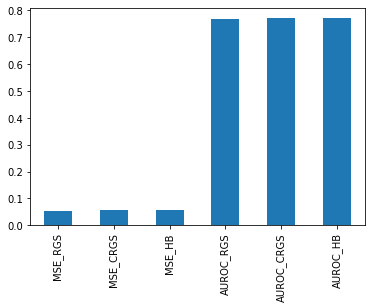

In [6]:
dataset_name = 'Jester'
datasets[dataset_name]["dataframe"].mean().plot(kind='bar')

In [72]:
columns=set()
for dataset_name in datasets.keys():
    for column in datasets[dataset_name]['dataframe'].columns:
        columns.add(column)

In [78]:
mean_dataframe = pd.DataFrame(columns=columns)
standard_deviation_dataframe = pd.DataFrame(columns=columns)

In [79]:
for dataset_name in datasets.keys():
    mean_series = datasets[dataset_name]['dataframe'].mean()
    mean_series.name = dataset_name
    mean_dataframe = mean_dataframe.append(mean_series)
    
    standard_deviation_series = datasets[dataset_name]['dataframe'].std()
    standard_deviation_series.name = dataset_name
    standard_deviation_dataframe = standard_deviation_dataframe.append(standard_deviation_series)

In [90]:
performance_dataframe = standard_deviation_dataframe.join(mean_dataframe, lsuffix='_std', rsuffix='_mean')
performance_dataframe = performance_dataframe.reindex(sorted(performance_dataframe.columns), axis=1)
performance_dataframe.to_csv("performance_study_results.csv")

In [68]:
mean_dataframe

,RGS_MSE,CRGS_F1,HB_MSE,HB_F1,RGS_F1,RGS_Accuracy,HB_Accuracy,CRGS_MSE,CRGS_Accuracy,RGS_AUROC,HB_AUROC,CRGS_AUROC
Jester,0.052152,NaN,0.057141,NaN,NaN,NaN,NaN,0.055238,NaN,0.769814,0.770900,0.771078
Epinions,NaN,0.957941,NaN,0.957346,0.964475,NaN,NaN,NaN,NaN,0.811908,0.808821,0.814475
Cora,NaN,0.855506,NaN,0.857889,0.866319,0.832990,0.836037,NaN,0.833914,NaN,NaN,NaN
Citeseer,NaN,0.788449,NaN,0.785321,0.797617,0.741013,0.743053,NaN,0.744561,NaN,NaN,NaN
LastFM,0.078146,NaN,0.091716,NaN,NaN,NaN,NaN,0.091716,NaN,0.598016,0.594382,0.594382


In [26]:
columns

{'1', '2'}

In [10]:
l=[0,12]

In [12]:
l.mean()

AttributeError: 'list' object has no attribute 'mean'